In [1]:
# !pip install --upgrade pip
# !pip3 install pandas
# !pip3 install scikit-learn
# !pip3 install optuna
# !pip install --upgrade wandb

In [2]:
# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

#General Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import gc
from tensorflow.keras import backend as K


# Experiments Managers
import optuna
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

2025-11-08 23:28:40.579032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 23:28:40.604024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 23:28:41.495728: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Define directory path and parameters
data_dir = '/tf/Tarea_6/images'
h = 256//2
w = 384//2
image_size = (h, w,3)
batch_size = 15

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/train',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size[:2],
    interpolation='bilinear',
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.7,
    subset='training',
    seed=42 # for reproducibility
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/test',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size[:2],
    interpolation='bilinear',
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.7,
    subset='training',
    seed=42,
)

Found 1092 files belonging to 4 classes.
Using 328 files for training.
Found 546 files belonging to 4 classes.
Using 164 files for training.


In [4]:
class_names = train_ds.class_names
class_names

['healthy', 'multiple_diseases', 'rust', 'scab']

In [5]:
num_of_classes = len(class_names)
num_of_classes

4

In [6]:
def data_augmentation(x):
    x = layers.RandomColorJitter(
        [0,255],
        None,
        [-0.2,0.2],
        [0.59,0.61],
    )(x)
    x = layers.RandomZoom(0.2)(x)
    x = layers.RandomRotation(0.1)(x)
    return x

2025-11-08 23:28:46.170418: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


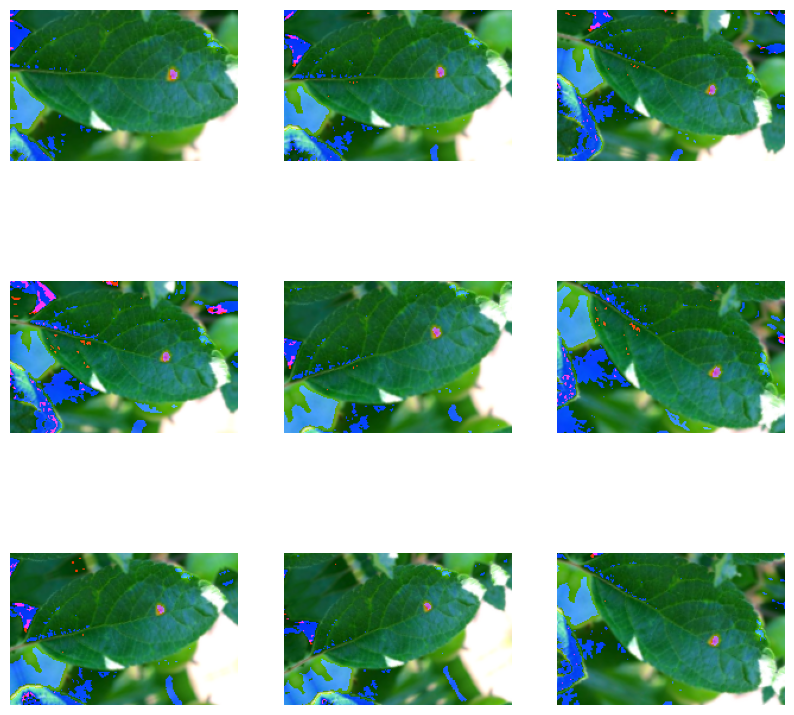

In [7]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PretrainedModelBuilder:
    def __init__(self, trial, num_of_classes=4, image_size=(h, w,3)):
        self.image_size = image_size
        self.num_of_classes = num_of_classes
        self.inputs = keras.Input(image_size)
        self.base_model = DenseNet121(
            include_top=False,weights='imagenet',
            input_shape=image_size,
            input_tensor=self.inputs,pooling=None
        )
        self.base_model.trainable = False
        self.dense_layers = trial.suggest_int(
            'total_dense_layers',1,2)
        self.learning_rate = trial.suggest_float(
            'learning_rate',0.002,0.004
        )
        self.units = [None] * self.dense_layers
        self.dropouts = [None] * self.dense_layers
        self.activations = [None] * self.dense_layers
        self.regularizers = [None] * self.dense_layers
        self.act_categories = ['relu','leaky_relu','elu']
        self.opt_categories = ["Adam", "SGD", "RMSprop", "Nadam"]
        self.reg_categories = [None, 'L1', 'L2']
        self.optimizer = trial.suggest_categorical('optimizer', 
                                                   self.opt_categories)
        
        for i in range(self.dense_layers):
            self.units[i] = trial.suggest_int(
                f'activations_{i}',16,128,step=16)
            self.dropouts[i] = trial.suggest_float(
                f'dropouts_{i}',0.1,0.3)
            self.activations[i] = trial.suggest_categorical(
                f'activation_{i}', self.act_categories
            )
            self.regularizers[i] = trial.suggest_categorical(
                f'regularizer_{i}', self.reg_categories
            )
    def selected_regularizer(self, regularizer):
        if regularizer is None:
            return None
        elif regularizer == "L1L2":
            return regularizers.L1L2(l1=1e-5, l2=1e-5)
        elif regularizer == "L1":
            return regularizers.L1(1e-5)
        elif regularizer == "L2":
            return regularizers.L2(1e-5)
        
    def final_model(self):    
        x = self.inputs
        x = data_augmentation(x)
        x = layers.Rescaling(1./255)(x)
        x = self.base_model(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.25)(x) 
        
        for i in range(self.dense_layers):
            x = layers.Dense(
                units=self.units[i],
                activation=self.activations[i], 
                kernel_regularizer=self.selected_regularizer(
                    self.regularizers[i]
                ))(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(rate=self.dropouts[i])(x)
        
        x = layers.Dense(
            units=self.num_of_classes, 
            activation='softmax', 
            name='clasification_layer')(x)
        outputs = x
        return outputs
        
    def _model_build(self):
        model = keras.Model(inputs=self.inputs, 
                            outputs=self.final_model())
        model.compile(
            loss='categorical_crossentropy',
            optimizer=eval(f"keras.optimizers.{self.optimizer}(learning_rate={self.learning_rate})"),
            metrics=['accuracy']
        )
        return model
    def get_params(self):
        params = {'dense_layers':self.dense_layers,
                  'dense_units':self.units,
                  'dense_activations':self.activations,
                  'regularizers':self.regularizers,
                  'dense_dropouts':self.dropouts,
                  'learning_rate':self.learning_rate,
                  'optimizer': self.optimizer}
        return params

In [9]:
def objective(trial):
    # Initialize best tracking if not exists
    if not hasattr(objective, "best_val_loss"):
        objective.best_val_loss = float('inf')
        objective.best_trial_number = None

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0.0001,
                                                   patience=30, 
                                                   restore_best_weights=True,
                                                   mode="auto",
                                                   verbose=1,
                                                   baseline=None)

    builder = PretrainedModelBuilder(trial)
    params = builder.get_params()
    model = builder._model_build()

    # Start WandB run
    run = wandb.init(
        project='Plant_Diseases_DenseNet121',
        group='Full_Train_2',
        name=f'Trial_{trial.number}',
        config=params | {'best': 'no', 'trial_number': trial.number},
        reinit=True
    )
    
    try:
        history = model.fit(
            train_ds,
            epochs=1000, 
            batch_size=batch_size,
            verbose=0,
            validation_data=test_ds,
            callbacks=[
                WandbMetricsLogger(log_freq=20),
                early_stopping
            ]
        )
        
        val_loss, val_accuracy = model.evaluate(test_ds, verbose=0)
        
        # Determine if this is the best model
        is_best = val_loss < objective.best_val_loss
        if is_best:
            objective.best_val_loss = val_loss
            objective.best_trial_number = trial.number
        
        # Update WandB config with best status and final metrics
        wandb.config.update({
            'best': 'yes' if is_best else 'no',
            'final_val_loss': val_loss,
            'final_val_accuracy': val_accuracy,
            'best_val_loss_so_far': objective.best_val_loss,
            'best_trial_number_so_far': objective.best_trial_number
        }, allow_val_change=True)
        
        # Log final metrics
        wandb.log({
            'final_val_loss': val_loss,
            'final_val_accuracy': val_accuracy,
            'is_best_trial': is_best
        })
        
        final_val_loss = val_loss
        
    except Exception as e:
        print(f"Error in trial {trial.number}: {e}")
        final_val_loss = float('inf')
    
    finally:
        # Cleanup regardless of success or failure
        run.finish()
        
        # Clear TensorFlow session and free memory
        cleanup_gpu_memory(model)
        
        return final_val_loss

def cleanup_gpu_memory(model=None):
    """Clean up GPU memory and clear TensorFlow session"""
    try:
        # Delete model if provided
        if model is not None:
            del model
        
        # Clear TensorFlow session
        K.clear_session()
        
        # Force garbage collection
        gc.collect()
        
        # Clear TensorFlow GPU memory
        if tf.config.list_physical_devices('GPU'):
            # For TensorFlow 2.x
            gpus = tf.config.experimental.list_physical_devices('GPU')
            if gpus:
                try:
                    for gpu in gpus:
                        tf.config.experimental.set_memory_growth(gpu, True)
                    tf.config.experimental.reset_memory_stats('GPU:0')
                except RuntimeError as e:
                    print(f"GPU memory reset error: {e}")
        
        # Additional garbage collection
        gc.collect()
        
        print("GPU memory cleaned successfully")
        
    except Exception as e:
        print(f"Error during cleanup: {e}")

# Initialize the best tracking variables
objective.best_val_loss = float('inf')
objective.best_trial_number = None

# Configure your study
study = optuna.create_study(direction="minimize")

# Add callback for additional cleanup between trials (optional)
def callback(study, trial):
    print(f"Trial {trial.number} completed. Best value: {study.best_value}")
    # Additional cleanup if needed
    cleanup_gpu_memory()

# Run the optimization
study.optimize(objective, n_trials=50, callbacks=[callback])

[I 2025-11-08 23:28:46,353] A new study created in memory with name: no-name-c804060b-36a9-4b02-b3fd-2d83e895f8ac
wandb: Currently logged in as: luisedu04 (luisedu04-buap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


batch/accuracy,▂▁▁▂▄▂▃▂▄▃▅▄▅▄▅▄▅▄▅▅▅▅▇▆█▆█▆▄
batch/batch_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▆▃▆▆▅▆▅▃▄▄▄▅▄▂▄▂▃▃▃▃▃▁▃▂▃▄
epoch/accuracy,▁▂▃▃▄▅▆▆▆▇▇███
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▄▃▃▃▃▂▂▂▁▂
epoch/val_accuracy,▁▁▄▅▆▇▇▇█▇████
epoch/val_loss,█▇▇▆▅▅▄▃▃▂▂▂▁▁
batch/accuracy,0.46667


[W 2025-11-08 23:30:22,633] Trial 0 failed with parameters: {'total_dense_layers': 2, 'learning_rate': 0.0028352691241073226, 'optimizer': 'SGD', 'activations_0': 32, 'dropouts_0': 0.13445193021828736, 'activation_0': 'relu', 'regularizer_0': 'L2', 'activations_1': 128, 'dropouts_1': 0.1221452096375445, 'activation_1': 'elu', 'regularizer_1': 'L1'} because of the following error: UnboundLocalError("cannot access local variable 'final_val_loss' where it is not associated with a value").
Traceback (most recent call last):
  File "/tmp/ipykernel_1259/467158446.py", line 30, in objective
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

GPU memory cleaned successfully


UnboundLocalError: cannot access local variable 'final_val_loss' where it is not associated with a value